Basic imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


Load the data

In [33]:

df = pd.read_csv("data_churn.csv")

Data overview

In [34]:
print(df.head())
print(df.info())
print(df['Churn'].value_counts())

   Unnamed: 0  customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0           0  7590-VHVEG  Female              0     Yes         No       1   
1           1  5575-GNVDE    Male              0      No         No      34   
2           2  3668-QPYBK    Male              0      No         No       2   
3           3  7795-CFOCW    Male              0      No         No      45   
4           4  9237-HQITU  Female              0      No         No       2   

  PhoneService     MultipleLines InternetService  ... DeviceProtection  \
0           No  No phone service             DSL  ...               No   
1          Yes                No             DSL  ...              Yes   
2          Yes                No             DSL  ...               No   
3           No  No phone service             DSL  ...              Yes   
4          Yes                No     Fiber optic  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0 

Analysis and handling of missing data


=== Missing Data Analysis ===

Columns with missing data:
                 Count  Percentage
OnlineBackup      5558   79.971223
TotalCharges      2085   30.000000
TechSupport       1508   21.697842
StreamingTV       1508   21.697842
StreamingMovies   1508   21.697842

Total number of rows with at least one missing value: 6190
Percentage of rows with missing data: 89.06%


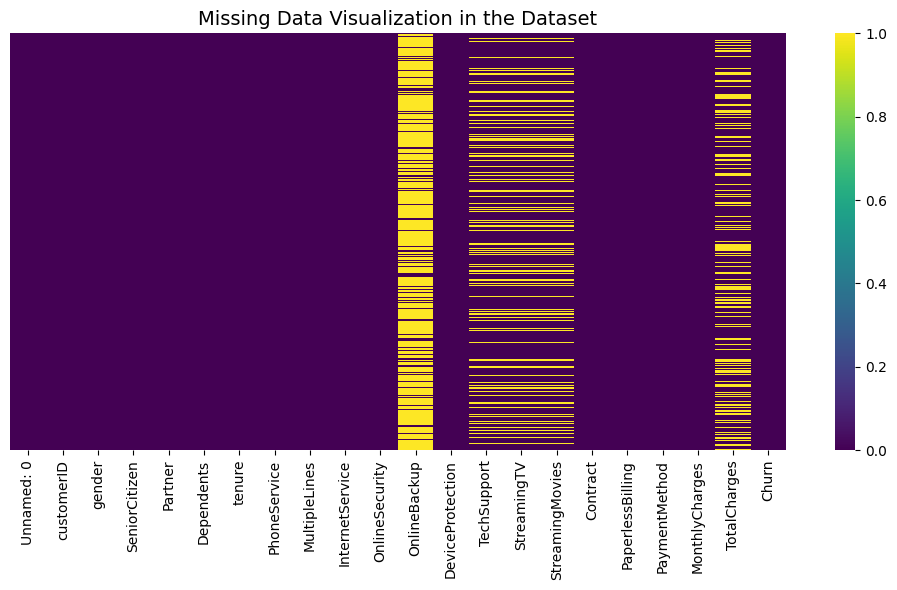

In [35]:
# Analysis of missing data
print("=== Missing Data Analysis ===\n")

# Number and percentage of missing values per column
missing_data = pd.DataFrame({
    'Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_data = missing_data[missing_data['Count'] > 0].sort_values('Count', ascending=False)

if len(missing_data) > 0:
    print("Columns with missing data:")
    print(missing_data)
    print(f"\nTotal number of rows with at least one missing value: {df.isnull().any(axis=1).sum()}")
    print(f"Percentage of rows with missing data: {(df.isnull().any(axis=1).sum() / len(df)) * 100:.2f}%")
    
    # Visualization of missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title("Missing Data Visualization in the Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

else:
    print("No missing data detected in the dataset.")


In [36]:
# Handling rows with missing data
print("=== Missing Data Handling ===\n")

# Count rows before deletion
nb_rows_before = len(df)
print(f"Number of rows before processing: {nb_rows_before}")

# Remove rows with too many missing values
missing_threshold = 0.5  # 50% of columns
df = df[df.isnull().sum(axis=1) / len(df.columns) < missing_threshold]

# Count rows after deletion
nb_rows_after = len(df)
nb_rows_deleted = nb_rows_before - nb_rows_after

print(f"Number of rows after deletion: {nb_rows_after}")
print(f"Number of rows deleted: {nb_rows_deleted}")
print(f"Percentage of data retained: {(nb_rows_after / nb_rows_before) * 100:.2f}%")

# Check if there are still missing data
if df.isnull().sum().sum() > 0:
    print("\nThere are still missing data that will be handled in the cleaning section.")
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("\nAll missing data has been handled.")


=== Missing Data Handling ===

Number of rows before processing: 6950
Number of rows after deletion: 6950
Number of rows deleted: 0
Percentage of data retained: 100.00%

There are still missing data that will be handled in the cleaning section.
OnlineBackup       5558
TechSupport        1508
StreamingTV        1508
StreamingMovies    1508
TotalCharges       2085
dtype: int64


Data cleaning

In [ ]:
# 1. Remove unnecessary columns
df = df.drop(columns=["Unnamed: 0", "customerID"])

# 2. Convert TotalCharges to numeric and handle NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0)  # very recent clients = not yet paid

# 3. Replace NaN in service columns with "No"
cols_with_na = ["OnlineBackup", "TechSupport", "StreamingTV", "StreamingMovies"]
for col in cols_with_na:
    df[col] = df[col].fillna("No")

# 4. Standardize "No internet service" and "No phone service" modalities
replace_map = {
    "No internet service": "No",
    "No phone service": "No"
}
df = df.replace(replace_map)

# 5. Encode target (Churn) as binary
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# 6. Check numeric / categorical columns
categorical_cols = df.select_dtypes(include="object").columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

print("Categorical columns:", list(categorical_cols))
print("Numeric columns:", list(numeric_cols))

# OneHot Encoding (better)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Final check
print(df.info())
print(df.head())


Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          6950 non-null   int64  
 1   tenure                                 6950 non-null   int64  
 2   MonthlyCharges                         6950 non-null   float64
 3   TotalCharges                           6950 non-null   float64
 4   Churn                                  6950 non-null   int64  
 5   gender_Male                            6950 non-null   bool   


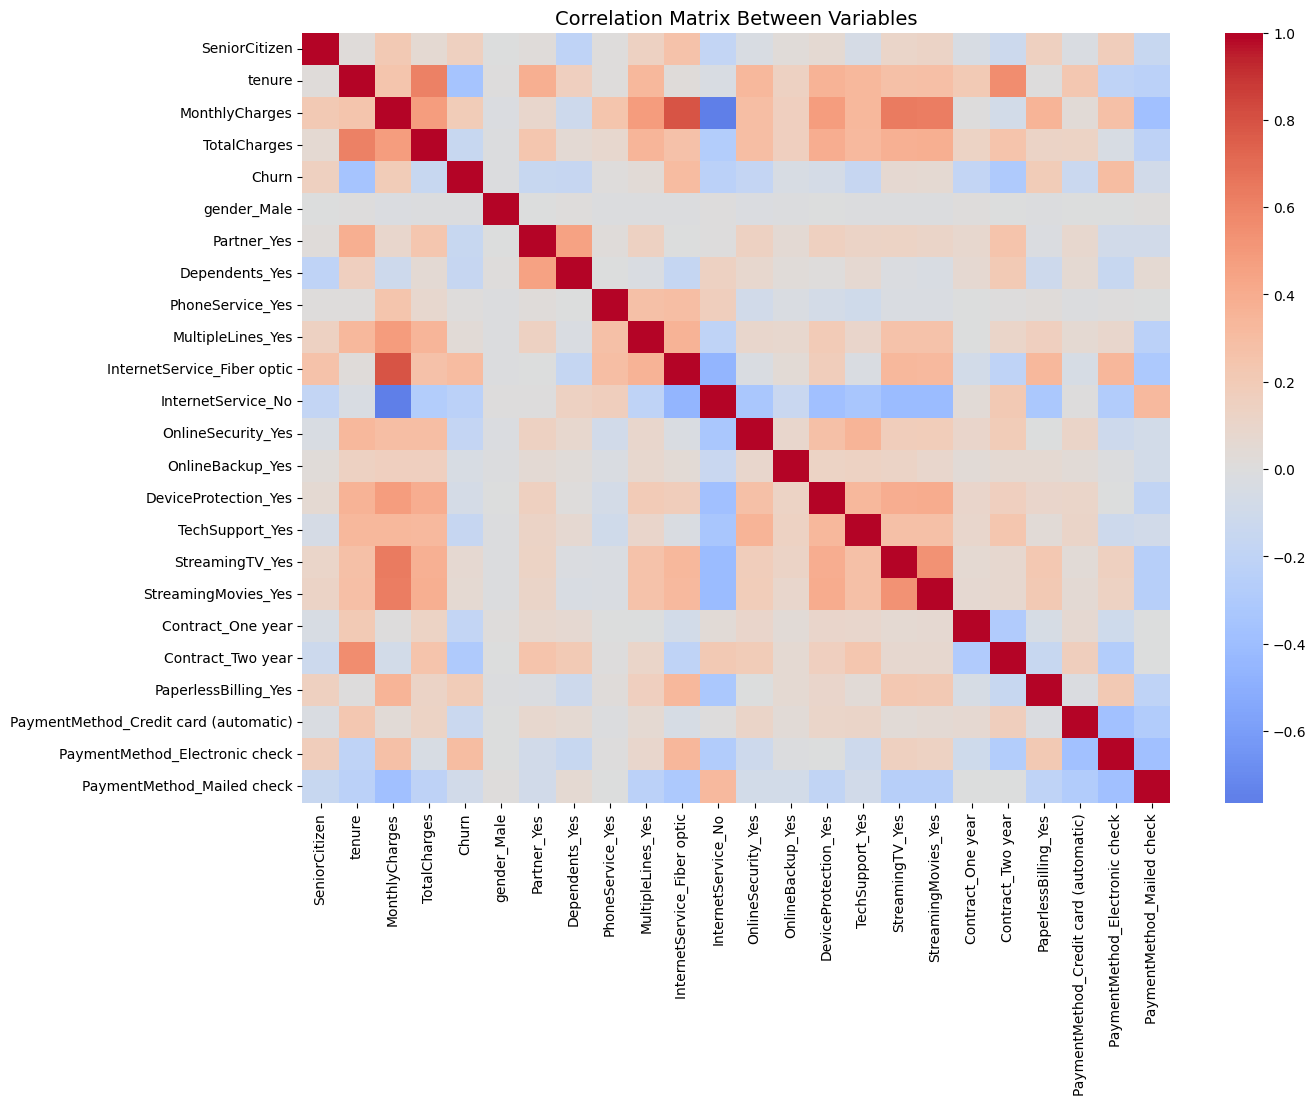

Correlations with Churn variable:

Churn                             1.000000
InternetService_Fiber optic       0.308195
PaymentMethod_Electronic check    0.301139
MonthlyCharges                    0.193192
PaperlessBilling_Yes              0.191729
SeniorCitizen                     0.151684
StreamingTV_Yes                   0.063215
StreamingMovies_Yes               0.059873
MultipleLines_Yes                 0.040252
PhoneService_Yes                  0.012059
Name: Churn, dtype: float64
PaymentMethod_Credit card (automatic)   -0.133408
TotalCharges                            -0.147548
Partner_Yes                             -0.150473
TechSupport_Yes                         -0.164115
Dependents_Yes                          -0.164207
OnlineSecurity_Yes                      -0.171954
Contract_One year                       -0.178916
InternetService_No                      -0.227531
Contract_Two year                       -0.301743
tenure                                  -0.352283
Name: C

In [38]:
# --- Step: Correlation Matrix ---

plt.figure(figsize=(14,10))

# Calculate correlations
corr = df.corr()

# Correlation heatmap with seaborn
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)

plt.title("Correlation Matrix Between Variables", fontsize=14)
plt.show()

# Focus on correlation with churn
corr_churn = corr["Churn"].sort_values(ascending=False)
print("Correlations with Churn variable:\n")
print(corr_churn.head(10))   # most positive
print(corr_churn.tail(10))   # most negative


Quick exploratory analysis

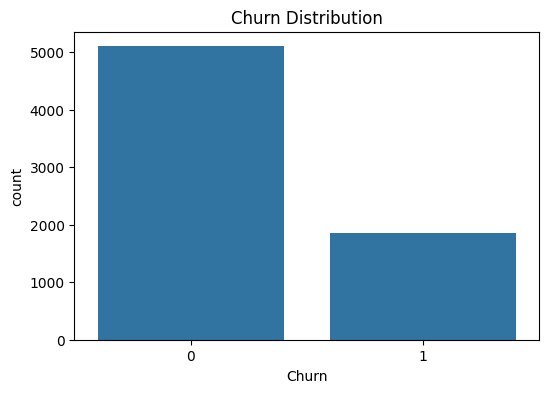

Percentage distribution:
Non churn: 73.41%
Churn: 26.59%


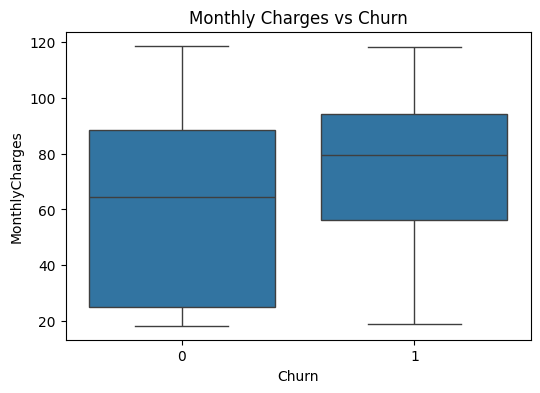

In [39]:
# 1. Churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

# Display percentages of churn and non-churn
churn_counts = df['Churn'].value_counts(normalize=True) * 100
print("Percentage distribution:")
for val, pct in churn_counts.items():
    label = "Churn" if val == 1 else "Non churn"
    print(f"{label}: {pct:.2f}%")

# 2. MonthlyCharges vs Churn
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()


Train/test split

In [40]:

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Standardization

In [41]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

First model: logistic regression

In [42]:

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# y_proba = model.predict_proba(X_test)[:,1]

print("Classification report :")
print(classification_report(y_test, y_pred))

Classification report :
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1531
           1       0.68      0.58      0.63       554

    accuracy                           0.82      2085
   macro avg       0.77      0.74      0.75      2085
weighted avg       0.81      0.82      0.81      2085



Confusion matrix

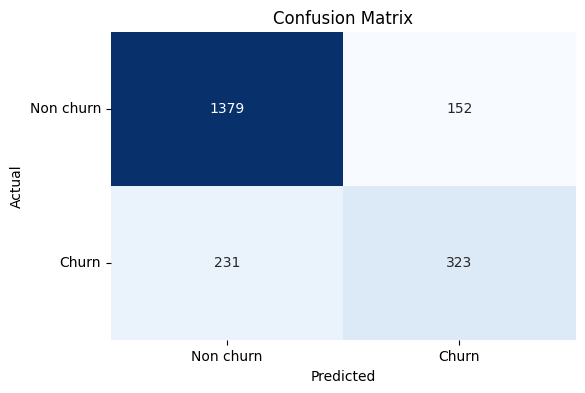

In [43]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["Non churn", "Churn"])
plt.yticks([0.5, 1.5], ["Non churn", "Churn"], rotation=0)
plt.show()

Variable importance

                           Feature      Coef
1                           tenure -0.882317
9      InternetService_Fiber optic  0.571539
18               Contract_Two year -0.495625
10              InternetService_No -0.385961
2                   MonthlyCharges -0.310694
17               Contract_One year -0.266429
16             StreamingMovies_Yes  0.225871
15                 StreamingTV_Yes  0.203468
21  PaymentMethod_Electronic check  0.166523
19            PaperlessBilling_Yes  0.164285


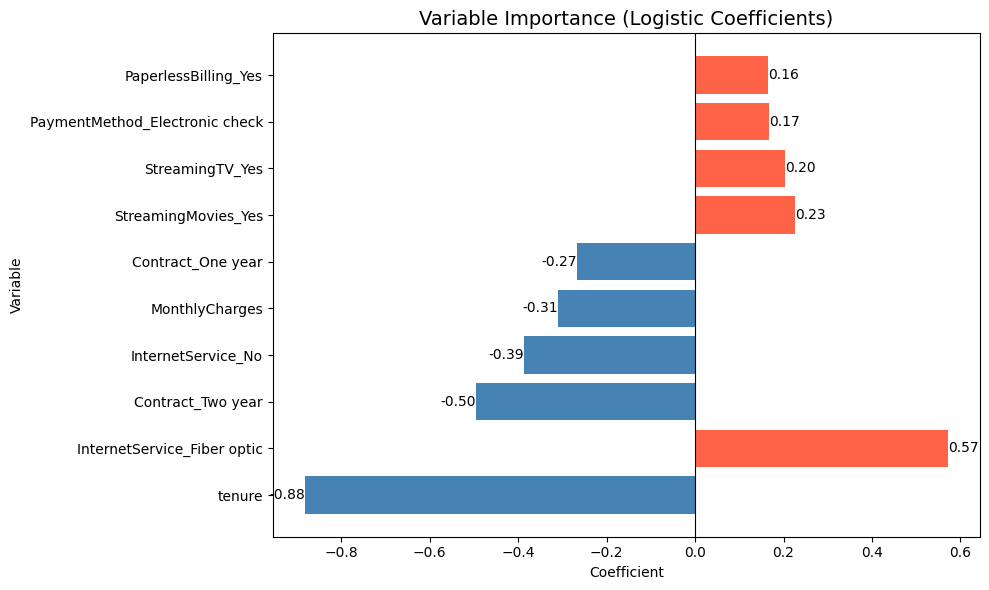

In [44]:

importance = pd.DataFrame({
    'Feature': X.columns,
    'Coef': model.coef_[0]
}).sort_values(by="Coef", key=abs, ascending=False)

print(importance.head(10))
# --- Variable Importance (Logistic Regression) ---

# Select the top 10 by absolute value
top_features = importance.head(10)

# Define colors: red if coef > 0 (risk ↑), blue if coef < 0 (loyalty ↑)
colors = ["tomato" if c > 0 else "steelblue" for c in top_features["Coef"]]

plt.figure(figsize=(10,6))
bars = plt.barh(top_features["Feature"], top_features["Coef"], color=colors)

plt.axvline(0, color="black", linewidth=0.8)
plt.title("Variable Importance (Logistic Coefficients)", fontsize=14)
plt.xlabel("Coefficient")
plt.ylabel("Variable")

# Add numeric values on bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", va='center',
             ha="left" if bar.get_width() > 0 else "right")

plt.tight_layout()
plt.show()

Encourages cancellation:
- Fiber connection

Promotes loyalty:
- Tenure
- Subscription price


Check business hypothesis: impact of number of services on churn

C:\Users\gabin\AppData\Local\Temp\ipykernel_32736\1876297359.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="nb_services", y="Churn", data=df, errorbar=None, palette="viridis")


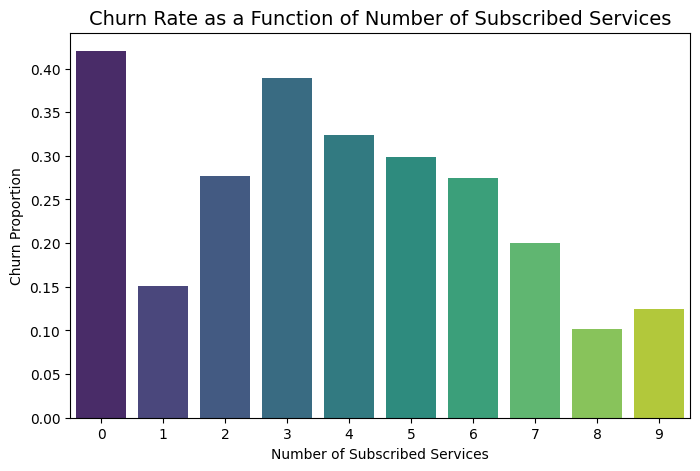

Correlation nb_services vs churn: 0.020

Churn rate by number of services:
 nb_services
0    0.420000
1    0.150969
2    0.277119
3    0.389362
4    0.324382
5    0.299046
6    0.274740
7    0.200431
8    0.102151
9    0.125000
Name: Churn, dtype: float64


In [45]:
# List of columns corresponding to subscribed services
service_cols = [
    "PhoneService_Yes",
    "MultipleLines_Yes",
    "InternetService_Fiber optic",
    "OnlineSecurity_Yes",
    "OnlineBackup_Yes",
    "DeviceProtection_Yes",
    "TechSupport_Yes",
    "StreamingTV_Yes",
    "StreamingMovies_Yes"
]

# Create a "nb_services" variable
df["nb_services"] = df[service_cols].sum(axis=1)

# Analysis: churn as a function of number of services
plt.figure(figsize=(8,5))
sns.barplot(x="nb_services", y="Churn", data=df, errorbar=None, palette="viridis")
plt.title("Churn Rate as a Function of Number of Subscribed Services", fontsize=14)
plt.ylabel("Churn Proportion")
plt.xlabel("Number of Subscribed Services")
plt.show()

# Check correlation
corr_nb_services = df["nb_services"].corr(df["Churn"])
print(f"Correlation nb_services vs churn: {corr_nb_services:.3f}")

# Detailed churn rate by nb_services
churn_by_services = df.groupby("nb_services")["Churn"].mean()
print("\nChurn rate by number of services:\n", churn_by_services)
